In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as f
import torchvision.models as models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import time

In [2]:
device = ('cuda' if torch.cuda.is_available else 'cpu')
device

'cuda'

## Load Data

In [3]:
image_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2,contrast=0.2),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),  
])

In [4]:
dataset_path = './dataset'
dataset = datasets.ImageFolder(root=dataset_path, transform=image_transform)
len(dataset)

2300

In [5]:
class_names = dataset.classes
class_names

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [6]:
num_classes = len(dataset.classes)
num_classes

6

In [7]:
train_size = int(0.75*len(dataset))
test_size = len(dataset)-train_size
train_size, test_size

(1725, 575)

In [8]:
from torch.utils.data import random_split
train_dataset, val_dataset = random_split(dataset, [train_size, test_size])

In [9]:
batch_size=32
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False)

In [10]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [11]:
images[1].shape

torch.Size([3, 224, 224])

In [12]:
images[1].permute(1,2,0).shape

torch.Size([224, 224, 3])

In [13]:
labels[1]

tensor(2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7511113].


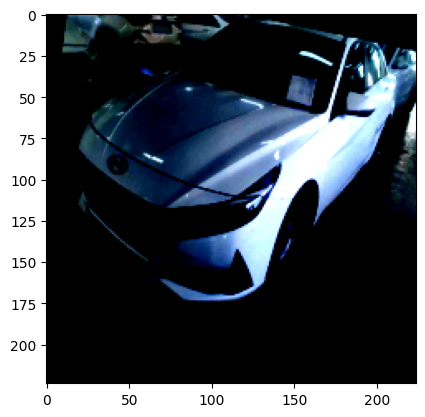

In [14]:
plt.imshow(images[1].permute(1,2,0))
plt.show()

## Model 1 CNN

In [15]:
class CarClassifierCNN(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.network=nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3,stride=1,padding=1),  #output (16,224,224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), #output (16, 112,112)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,stride=1,padding=1),  #output (32,112,112)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), #output (32, 56,56)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,stride=1,padding=1),  #output (64,56,56)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), #output (64, 28,28)


            nn.Flatten(),
            nn.Linear(64*28*28,512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
            
        )
    def forward(self,x):
        x = self.network(x)
        return x
        
    

In [16]:
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [17]:
len(train_loader.dataset)

1725

In [18]:
def train_model(model,criterion,optimizer,epochs=5):
    start = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss=0
        for batch ,(images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            if (batch+1)%10==0:
                print(f'Batch {batch+1}: epoch: {epoch+1} loss: {loss.item():0.2f}')
            running_loss+=loss.item()*images.size(0)
        epoch_loss=running_loss/len(train_loader.dataset)
        print(f'epoch: {epoch}/{epochs} avg_loss: {epoch_loss:0.2f}')

        #Model Evaluation
        model.eval()
        total=0
        correct=0
        all_labels=[]
        all_predicted=[]
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                output = model(images)
                _, predicted = torch.max(output.data,1)
                total+=labels.size(0)
                correct+=(predicted==labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predicted.extend(predicted.cpu().numpy())
            print(f'Validation accuracy {100* correct/total:0.2f}')
    end = time.time()
    print(f'Execution time {end-start}seconds')
    return all_labels, all_predicted


In [19]:
all_labels, all_predicted = train_model(model,criterion,optimizer,epochs=10)

Batch 10: epoch: 1 loss: 1.83
Batch 20: epoch: 1 loss: 1.74
Batch 30: epoch: 1 loss: 1.57
Batch 40: epoch: 1 loss: 1.66
Batch 50: epoch: 1 loss: 1.54
epoch: 0/10 avg_loss: 1.87
Validation accuracy 35.13
Batch 10: epoch: 2 loss: 1.40
Batch 20: epoch: 2 loss: 1.42
Batch 30: epoch: 2 loss: 1.42
Batch 40: epoch: 2 loss: 1.48
Batch 50: epoch: 2 loss: 1.11
epoch: 1/10 avg_loss: 1.40
Validation accuracy 48.87
Batch 10: epoch: 3 loss: 1.28
Batch 20: epoch: 3 loss: 1.25
Batch 30: epoch: 3 loss: 1.38
Batch 40: epoch: 3 loss: 1.30
Batch 50: epoch: 3 loss: 1.21
epoch: 2/10 avg_loss: 1.26
Validation accuracy 46.26
Batch 10: epoch: 4 loss: 1.08
Batch 20: epoch: 4 loss: 1.07
Batch 30: epoch: 4 loss: 1.39
Batch 40: epoch: 4 loss: 1.17
Batch 50: epoch: 4 loss: 0.85
epoch: 3/10 avg_loss: 1.17
Validation accuracy 51.48
Batch 10: epoch: 5 loss: 1.08
Batch 20: epoch: 5 loss: 1.20
Batch 30: epoch: 5 loss: 1.06
Batch 40: epoch: 5 loss: 1.24
Batch 50: epoch: 5 loss: 1.37
epoch: 4/10 avg_loss: 1.14
Validation 

## Model 2: CNN With Regularization

In [20]:
class CarClassifierCNNwithRegularization(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.network=nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3,stride=1,padding=1),  #output (16,224,224)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), #output (16, 112,112)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,stride=1,padding=1),  #output (32,112,112)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), #output (32, 56,56)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,stride=1,padding=1),  #output (64,56,56)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), #output (64, 28,28)


            nn.Flatten(),
            nn.Linear(64*28*28,512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
            
        )
    def forward(self,x):
        x = self.network(x)
        return x
        

In [21]:
model = CarClassifierCNNwithRegularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-4)

all_labels, all_predicted = train_model(model,criterion,optimizer,epochs=10)

Batch 10: epoch: 1 loss: 13.10
Batch 20: epoch: 1 loss: 5.72
Batch 30: epoch: 1 loss: 2.17
Batch 40: epoch: 1 loss: 1.55
Batch 50: epoch: 1 loss: 1.68
epoch: 0/10 avg_loss: 8.84
Validation accuracy 38.78
Batch 10: epoch: 2 loss: 1.63
Batch 20: epoch: 2 loss: 1.67
Batch 30: epoch: 2 loss: 1.39
Batch 40: epoch: 2 loss: 1.45
Batch 50: epoch: 2 loss: 1.61
epoch: 1/10 avg_loss: 1.48
Validation accuracy 44.87
Batch 10: epoch: 3 loss: 1.52
Batch 20: epoch: 3 loss: 1.22
Batch 30: epoch: 3 loss: 1.36
Batch 40: epoch: 3 loss: 1.12
Batch 50: epoch: 3 loss: 1.04
epoch: 2/10 avg_loss: 1.37
Validation accuracy 45.91
Batch 10: epoch: 4 loss: 1.15
Batch 20: epoch: 4 loss: 1.25
Batch 30: epoch: 4 loss: 1.06
Batch 40: epoch: 4 loss: 0.99
Batch 50: epoch: 4 loss: 1.12
epoch: 3/10 avg_loss: 1.27
Validation accuracy 47.83
Batch 10: epoch: 5 loss: 1.05
Batch 20: epoch: 5 loss: 1.14
Batch 30: epoch: 5 loss: 1.70
Batch 40: epoch: 5 loss: 1.14
Batch 50: epoch: 5 loss: 1.17
epoch: 4/10 avg_loss: 1.24
Validation

## Model 3: Transfer Learning Using EfficientNet

In [22]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')

        for param in self.model.parameters():
            param.requires_grad=False
        # Get number of input features to the classifier
        self.in_features = self.model.classifier[1].in_features  # Layer 1 is the Linear layer

        self.model.classifier=nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.in_features,num_classes)
        )
    def forward(self,x):
        x=self.model(x)
        return x

            

In [23]:
model=CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(filter(lambda p:p.requires_grad,model.parameters()),lr=0.001)

all_labels, all_predicted = train_model(model,criterion,optimizer,epochs=10)

Batch 10: epoch: 1 loss: 1.60
Batch 20: epoch: 1 loss: 1.59
Batch 30: epoch: 1 loss: 1.49
Batch 40: epoch: 1 loss: 1.24
Batch 50: epoch: 1 loss: 1.41
epoch: 0/10 avg_loss: 1.50
Validation accuracy 54.09
Batch 10: epoch: 2 loss: 1.18
Batch 20: epoch: 2 loss: 1.10
Batch 30: epoch: 2 loss: 1.13
Batch 40: epoch: 2 loss: 1.11
Batch 50: epoch: 2 loss: 1.07
epoch: 1/10 avg_loss: 1.14
Validation accuracy 61.91
Batch 10: epoch: 3 loss: 1.06
Batch 20: epoch: 3 loss: 1.09
Batch 30: epoch: 3 loss: 0.97
Batch 40: epoch: 3 loss: 0.80
Batch 50: epoch: 3 loss: 0.91
epoch: 2/10 avg_loss: 1.03
Validation accuracy 66.09
Batch 10: epoch: 4 loss: 0.97
Batch 20: epoch: 4 loss: 0.94
Batch 30: epoch: 4 loss: 0.84
Batch 40: epoch: 4 loss: 0.98
Batch 50: epoch: 4 loss: 0.99
epoch: 3/10 avg_loss: 0.95
Validation accuracy 66.43
Batch 10: epoch: 5 loss: 0.93
Batch 20: epoch: 5 loss: 0.86
Batch 30: epoch: 5 loss: 0.90
Batch 40: epoch: 5 loss: 0.80
Batch 50: epoch: 5 loss: 1.03
epoch: 4/10 avg_loss: 0.90
Validation 

In [42]:
class CarClassifierResNet(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.model=models.resnet50(weights='DEFAULT')

        #Freeze all Layer
        for param in self.model.parameters():
            param.requires_grad=False

        # Unfreeze layer4
        for param in self.model.layer4.parameters():
            param.requires_grad = True


        #Replace Fully Connected Layer
        self.model.fc=nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.model.fc.in_features,num_classes)
        )

    def forward(self,x):
        x=self.model(x)
        return x

In [43]:
model = CarClassifierResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad ,model.parameters()),lr=0.001)

all_labels, all_predicted = train_model(model,criterion,optimizer,epochs=10)

Batch 10: epoch: 1 loss: 0.91
Batch 20: epoch: 1 loss: 0.62
Batch 30: epoch: 1 loss: 0.76
Batch 40: epoch: 1 loss: 0.71
Batch 50: epoch: 1 loss: 0.57
epoch: 0/10 avg_loss: 0.87
Validation accuracy 72.87
Batch 10: epoch: 2 loss: 0.54
Batch 20: epoch: 2 loss: 0.29
Batch 30: epoch: 2 loss: 0.33
Batch 40: epoch: 2 loss: 0.40
Batch 50: epoch: 2 loss: 0.64
epoch: 1/10 avg_loss: 0.46
Validation accuracy 77.57
Batch 10: epoch: 3 loss: 0.38
Batch 20: epoch: 3 loss: 0.55
Batch 30: epoch: 3 loss: 0.47
Batch 40: epoch: 3 loss: 0.34
Batch 50: epoch: 3 loss: 0.20
epoch: 2/10 avg_loss: 0.37
Validation accuracy 77.39
Batch 10: epoch: 4 loss: 0.20
Batch 20: epoch: 4 loss: 0.16
Batch 30: epoch: 4 loss: 0.12
Batch 40: epoch: 4 loss: 0.24
Batch 50: epoch: 4 loss: 0.21
epoch: 3/10 avg_loss: 0.24
Validation accuracy 79.13
Batch 10: epoch: 5 loss: 0.22
Batch 20: epoch: 5 loss: 0.20
Batch 30: epoch: 5 loss: 0.24
Batch 40: epoch: 5 loss: 0.20
Batch 50: epoch: 5 loss: 0.15
epoch: 4/10 avg_loss: 0.21
Validation 

i tried the Hyper-parameter tunning using optuna is different notebook for lr and dropout values the best values are lr=0.002 Dropout=0.2

In [61]:
all_labels[5:10], all_predicted[5:10]

([np.int64(5), np.int64(1), np.int64(0), np.int64(1), np.int64(0)],
 [np.int64(4), np.int64(1), np.int64(0), np.int64(1), np.int64(0)])

In [45]:
from sklearn.metrics import classification_report,confusion_matrix
rep = classification_report(all_labels,all_predicted)
print(rep)

              precision    recall  f1-score   support

           0       0.86      0.81      0.83       127
           1       0.74      0.70      0.72       101
           2       0.82      0.90      0.86       117
           3       0.83      0.75      0.79        79
           4       0.61      0.70      0.65        67
           5       0.81      0.80      0.80        84

    accuracy                           0.79       575
   macro avg       0.78      0.78      0.78       575
weighted avg       0.79      0.79      0.79       575



In [46]:
matrix=confusion_matrix(all_labels,all_predicted)

Text(50.722222222222214, 0.5, 'The label')

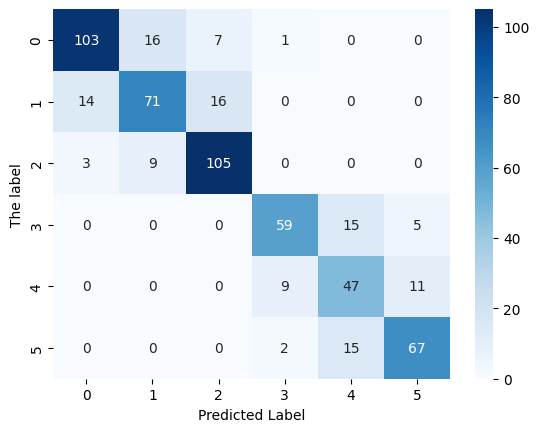

In [47]:
import seaborn as sns
sns.heatmap(matrix,annot=True,fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('The label')

In [62]:
torch.save(model.state_dict(),'saved_model.pth')